# HW3_1 - Expectation Maximization and Principal Component Analysis

Learning contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

#### We use `iris` dataset from `sklearn`

(<matplotlib.collections.PathCollection at 0x144f52c40>,
 <matplotlib.legend.Legend at 0x144f52ac0>)

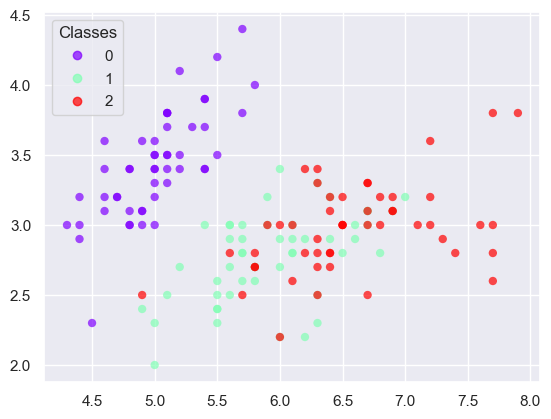

In [2]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

`gaussian_mixture` takes data point (vector) `x`, set of multivariate `means` and respective `covariances`, and `pis` (coeficients) and should return Probability Density Function value at point x.

In [3]:
def gaussian_mixture(x, means, covariances, pis):
    N = len(means)
    prob = 0
    for i in range(N):
        prob += pis[i] * multivariate_normal.pdf(x, means[i], covariances[i])
    return prob

`expectation_maximization_gaussian` takes initial means `mus_0`, covariances `covariances_0` and coeficients `pis_0`, data set `data_x` and callback `on_step`.

`on_step` is a function that takes current set of `mus`, corresponding `covariances` and `pis`, value of `log_likelihood` and list of class `predictions` for each point (\[0...k\]) and should be called each step 

In [4]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x, on_step):
    max_iter = 100
    n, d = data_x.shape
    k = mus_0.shape[0]
    mus = mus_0
    covariances = covariances_0
    pis = pis_0
    log_likelihoods = []

    for iteration in range(max_iter):
        # E step
        responsibilities = np.zeros((n, k))
        for i in range(k):
            responsibilities[:, i] = pis[i] * multivariate_normal.pdf(data_x, mus[i], covariances[i])
        sum_responsibilities = responsibilities.sum(axis=1)
        responsibilities = responsibilities / sum_responsibilities[:, np.newaxis]

        # M step
        pis = responsibilities.sum(axis=0) / n
        for i in range(k):
            mus[i] = (responsibilities[:, i][:, np.newaxis] * data_x).sum(axis=0) / responsibilities[:, i].sum()
            covariances[i] = np.cov(data_x.T, aweights=(responsibilities[:, i]), ddof=0)
        
        log_likelihood = np.log(sum_responsibilities).sum()
        log_likelihoods.append(log_likelihood)
        on_step(mus, covariances, pis, log_likelihood, responsibilities.argmax(axis=1))
    return mus, covariances, pis, log_likelihoods

### 1.1) Display results

In [5]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

In [6]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x,
    lambda mus, covs, pis, log_likelihood, predictions: all_steps_em.append((mus, covs, pis, log_likelihood, predictions))
)

(array([[6.93396792, 3.07596522],
        [6.09082726, 2.82159833],
        [5.02297885, 3.46514129]]),
 array([[[ 0.25264419, -0.08629911],
         [-0.08629911,  0.04097235]],
 
        [[ 0.37237825,  0.13613457],
         [ 0.13613457,  0.11403442]],
 
        [[ 0.12157121,  0.08853064],
         [ 0.08853064,  0.11728049]]]),
 array([0.12824257, 0.55963265, 0.31212478]),
 [-374.1746910106715,
  -266.88358494259865,
  -266.07555056400315,
  -265.25590188299896,
  -264.0623227411192,
  -262.2693713764819,
  -259.70081096319535,
  -256.5431998086615,
  -253.72497275277598,
  -251.8295772328316,
  -250.4472657240023,
  -249.16132101060205,
  -247.65327740576842,
  -245.53119610547066,
  -242.2366687667806,
  -237.0396436272738,
  -230.09805716140815,
  -224.7965235996385,
  -222.79487665028307,
  -221.8375167286663,
  -221.1023657199768,
  -220.48791718433733,
  -220.03866330826892,
  -219.75601052880802,
  -219.58091673839468,
  -219.46083622852916,
  -219.36467456882593,
  -219.27

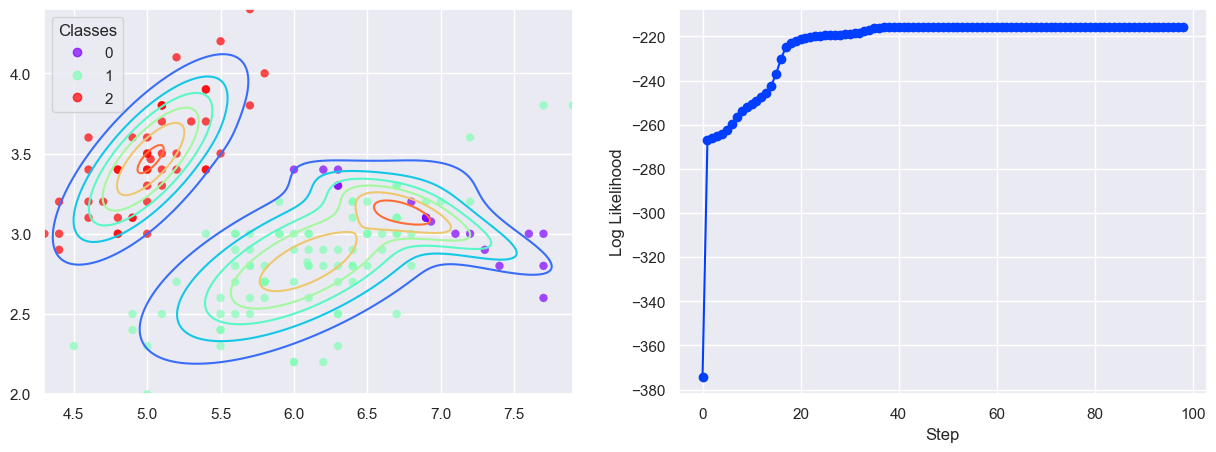

In [7]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

### 1.2) Nearest Centroid-based classification

`nearest_centroid_based_class` takes data point `x`, set of means `mus` and `covariances` and returns class of this point

In [8]:
def nearest_centroid_based_class(x, mus, covariances):
    distances = [multivariate_normal.pdf(x, mus[i], covariances[i]) for i in range(len(mus))]
    return np.argmax(distances)

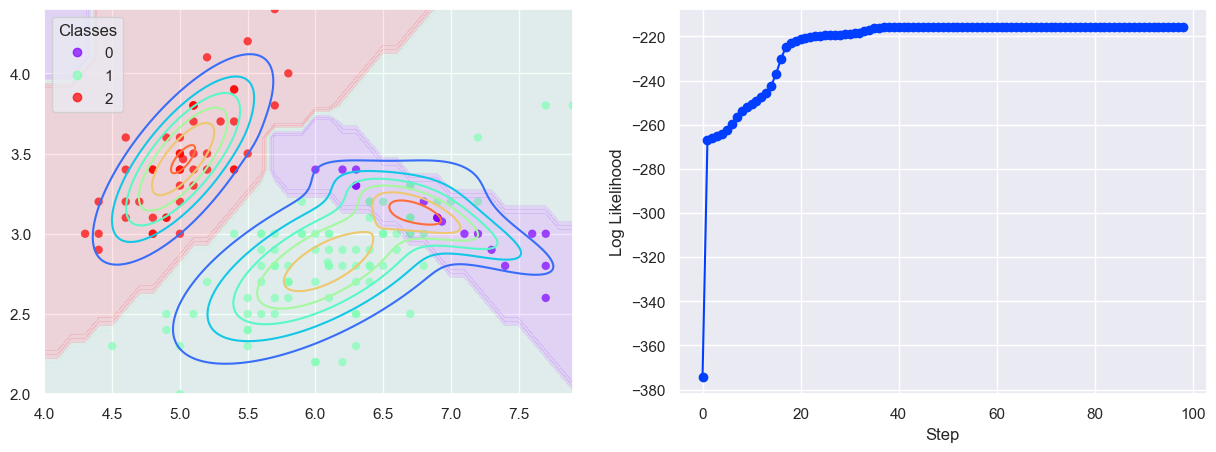

In [9]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

## 2) Principal Component Analysis

### 2.1) Generate data

In [10]:
iris4_x = np.array(iris.data[:, :4])

def plot_classes_3d(data, classes):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.show()
plot_classes_3d(iris4_x[:, :3], iris_t)

<Figure size 800x600 with 0 Axes>

### 2.3) Apply PCA

`pca_projection` takes data points `data`, number of `components` as arguments and returns PCA projection of the data

In [11]:
from sklearn.decomposition import PCA

def pca_projection(data, components):
    pca = PCA(n_components=components)
    projected_data = pca.fit_transform(data)
    return projected_data

### 2.4) Display projection

(<matplotlib.collections.PathCollection at 0x14953f5b0>,
 <matplotlib.legend.Legend at 0x145dcab50>)

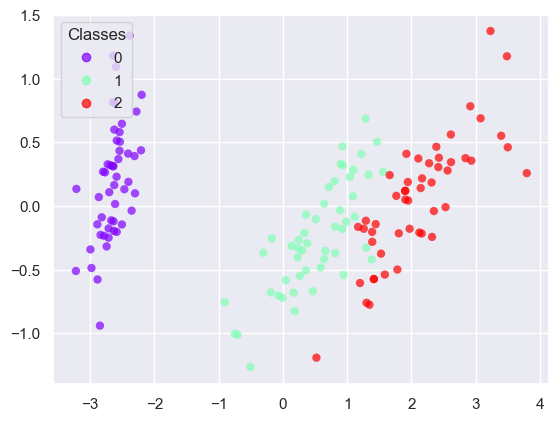

In [12]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)

In [13]:
projected_data = pca_projection(iris4_x, 3)
plot_classes_3d(projected_data, iris_t)

<Figure size 800x600 with 0 Axes>